# 140. User-Item based Collaborative Filtering - Matrix Factorization

## Keras로 MF(Matrix Factorization) 구현하기 - GPU 필요 / Colab 사용


### MF 방식의 원리

<img src="https://petamind.com/wp-content/uploads/2019/12/ml-mf-matrix-factorization-_op.svg" width=400 />

$$R \approx P\times Q^T=\hat{R}$$

R: Rating matrix, P: User latent matrix, Q: Item latent matrix, k: latent factor(잠재 요인), $\hat{R}$: 예측값

- R 행렬의 각 element는 해당 사용자 아이템에 대한 평점. 이 행렬은 사용자가 실제로 평가한 아이템에 대한 평점만을 가지고 있으므로 많은 원소가 null 로 채워진 sparse matrix 이다.
- R 행렬을 사용자 행렬 (P)와 아이템 행렬(Q)로 쪼개어 분석하는 방법이  MF  
- $\hat{R}$이 최대한 R에 가까운 값을 가지도록 하는 P와 Q를 구하면 그 것이 바로 추천을 위한 model이 된다.

$$\hat{r_{ij}}=b+bu_i + bd_j + \sum_{k=1}^k{p_{ik}q_{kj}}$$

$\hat{r_{ij}}$: 사용자 i 의 아이템 j 에  대한 예측값,  
b: 전체 평균. 일단 데이터가 주어지면 하나로 정해지는 값   
$bu_i$: 전체 평균을 제거한 후 사용자 i의 평가 경향(사용자 i의 평균과 전체 평균의 차이)     
$bd_j$: 전체 평균을 제거한 후 아이템 j의 평가 경향(아이템 j의 평균과 전체 평균의 차이)   
$p_{ik}$: 행렬 P의 i 번째 사용자 vector    
$q_{kj}$: 행렬 Q의 column j 번째 item vector

### MF 를 신경망으로 구현

<img src="https://ichi.pro/assets/images/max/724/1*VqQ5B6ah4KhbDKNBgX-cfg.png" />

- Input Layer 는 one-hot-encoding 과 같다.
- Embedding Layer 는 latent factor d 에 해당.  
- 사용자와 아이템의 경향성(bias)을 feature 가 1 인  Embedding 으로 구현  
- 전체 평균(b)는 하나의 숫자이므로 신경망의 target value에서 일률적으로 빼 주고, 나중에 산출된 예측치에 일률적으로 더해주는 것이 전체 평균을 모델화 하는 것 보다 간단함.

In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten,  Concatenate, Dense

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
url = "https://raw.githubusercontent.com/ironmanciti/Recommenders_Lecture/main/data/u.rating"
ratings = pd.read_csv(url, names=r_cols,  sep='\t',encoding='latin-1')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)            # timestamp 제거
ratings.head()

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [2]:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
url = "https://raw.githubusercontent.com/ironmanciti/Recommenders_Lecture/main/data/u.user"
users = pd.read_csv(url, sep='|', names=u_cols, encoding='latin-1')
users = users[['user_id', 'age', 'sex']]
users['age'] = users['age'] / users['age'].max()
users.head()

,user_id,age,sex
0,1,0.328767,M
1,2,0.726027,F
2,3,0.315068,M
3,4,0.328767,M
4,5,0.452055,F


In [3]:
ratings = pd.merge(ratings, users, on='user_id')
ratings = pd.get_dummies(ratings)
ratings.head()

,user_id,movie_id,rating,age,sex_F,sex_M
0,196,242,3,0.671233,0,1
1,196,393,4,0.671233,0,1
2,196,381,4,0.671233,0,1
3,196,251,3,0.671233,0,1
4,196,655,5,0.671233,0,1


In [4]:
target_ratings = ratings.pop('rating')

In [5]:
ratings.head(2)

,user_id,movie_id,age,sex_F,sex_M
0,196,242,0.671233,0,1
1,196,393,0.671233,0,1


In [6]:
others_input_shape = ratings.iloc[:, 2:].values.shape[1]
others_input_shape

3

In [7]:
# train test set 분리
train_ratings, test_ratings, train_targets, test_targets = train_test_split(ratings, target_ratings, test_size=0.2, random_state=0)
train_ratings.shape, test_ratings.shape, train_targets.shape, test_targets.shape

((80000, 5), (20000, 5), (80000,), (20000,))

In [8]:
K = 100      # 잠재 요인(latent factor)의 수
mu = train_targets.mean()    # 전체 평점의 평균
M = ratings.user_id.max() + 1       # 사용자 수 - 임베딩이 0부터 시작하므로 +1
N = ratings.movie_id.max() + 1      # 영화 수

K, mu, M, N

(100, 3.53185, 944, 1683)

In [9]:
# 사용자 임베딩의 shape 확인
# 사용자 수(M)와 잠재 요인의 수(K)를 기반으로 한 임베딩 행렬에서
# 하나의 사용자 임베딩 벡터를 가져온 후 그 shape을 출력
Embedding(M, K)(0).shape

TensorShape([100])

### Shallow Neural Network

<img src="https://petamind.com/wp-content/uploads/2019/12/ml-mf-matrix-factorization-_op.svg" width=400 />

$$\hat{r}_{ij} = b + bu_i + bd_i + \sum_1^k{p_{ik}q_{jk}}$$
  
k :  잠재 요인(latent factor)의 수   
$\hat{r}_{ij}$ : 사용자 i의 아이템 j에 대한 예측값  
b : 전체 평균 (데이터가 주어지면 하나로 정해지는 상수)  
$bu_i$ : 전체 평균을 제거한 후 사용자 i의 평가 경향 (사용자 i의 평균과 전체 평균의 차이)  
$bd_i$ : 전체 평균을 제거한 후 아이텐 j의 평가 경향 (아이템 j의 평균과 전체 평균의 차이)  
$p_{ik}$ : 행렬 P의 i번째 사용자 vector  
$q_{jk}$ : 행렬 Q의 column j 번째 item vector  

In [10]:
user = Input(shape=(1, ), name="p_ik")      # 사용자 입력
item = Input(shape=(1, ), name="q_kj")      # Item 입력
other_features = Input(shape=(others_input_shape,), name="other features")  # 기타 특성 입력
P_embedding = Embedding(M, K, name="P")(user)   # 사용자 임베딩 레이어 (M, K)
Q_embedding = Embedding(N, K, name="Q")(item)   # Item 임베딩 레이어 (N, K)

user_bias = Embedding(M, 1, name="bu")(user)     # 사용자 편향 (M, 1)
item_bias = Embedding(N, 1, name="bd")(item)     # Item 편향 (N, 1)

# Concatenate를 위해 임베딩 레이어들을 1차원으로 flatten
P_embedding = Flatten()(P_embedding)           #(K,)
Q_embedding = Flatten()(Q_embedding)           #(K,)
user_bias = Flatten()(user_bias)               #(1,)
item_bias = Flatten()(item_bias)               #(1,)

# 4개의 임베딩 레이어와 기타 특성들을 concatenate
x = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, other_features])
# Hidden Layer로 연결
x = Dense(1024, activation='relu')(x)
x = Dense(64, activation='relu')(x)
Rating = Dense(1)(x)

# 모델 설정
model = Model(inputs=[user, item, other_features], outputs=Rating)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 p_ik (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 q_kj (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 P (Embedding)               (None, 1, 100)               94400     ['p_ik[0][0]']                
                                                                                                  
 Q (Embedding)               (None, 1, 100)               168300    ['q_kj[0][0]']                
                                                                                              

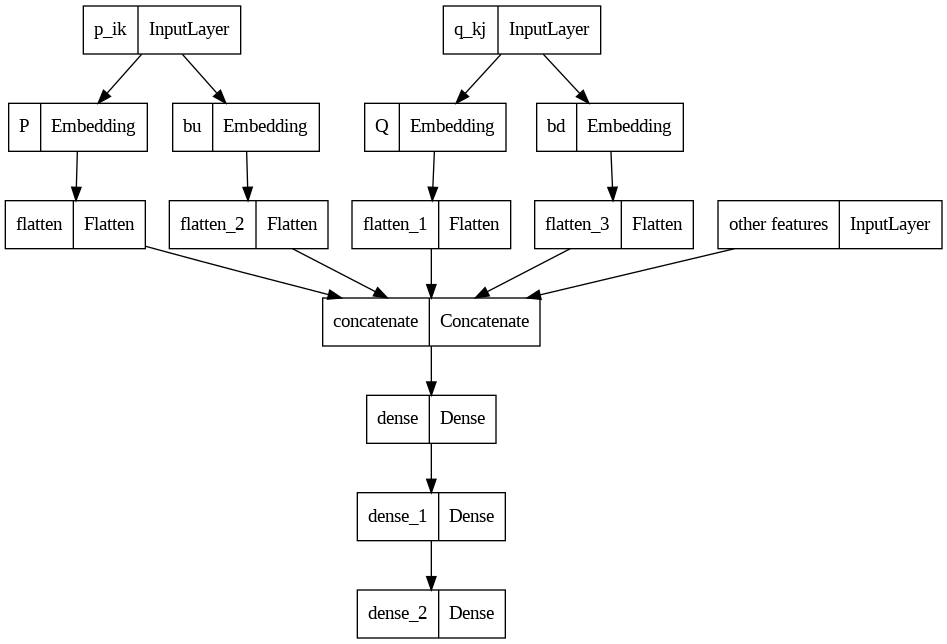

In [11]:
tf.keras.utils.plot_model(model)

In [12]:
model.compile(
  loss="mse",                                            # 손실 함수로 평균 제곱 오차(MSE) 사용
  optimizer="sgd",                                       # 최적화 알고리즘으로 확률적 경사 하강법(SGD) 사용
  metrics=["mae"]                                        # 평가 지표로 MSE 사용
)

In [13]:
history = model.fit(
    [train_ratings.user_id.values, train_ratings.movie_id.values, train_ratings.iloc[:, 2:].astype('float32').values],  # 사용자 ID, 영화 ID, 기타 특성들을 float32 타입으로 변환
    train_targets.values.astype('float32') - mu,  # 타겟 값에서 평균을 뺀 후 float32 타입으로 변환
  epochs=30,
  batch_size=256,
  validation_data=(
    [test_ratings.user_id.values, test_ratings.movie_id.values, test_ratings.iloc[:, 2:].astype('float32').values],  # 검증 데이터도 동일하게 타입 변환
    test_targets.values.astype('float32') - mu  # 타겟 값에서 평균을 뺀 후 float32 타입으로 변환
  )
)

Epoch 1/30
313/313 [==============================] - 20s 49ms/step - loss: 1.2615 - mae: 0.9426 - val_loss: 1.2751 - val_mae: 0.9479
Epoch 2/30
313/313 [==============================] - 3s 9ms/step - loss: 1.2575 - mae: 0.9408 - val_loss: 1.2718 - val_mae: 0.9458
Epoch 3/30
313/313 [==============================] - 2s 5ms/step - loss: 1.2534 - mae: 0.9391 - val_loss: 1.2680 - val_mae: 0.9427
Epoch 4/30
313/313 [==============================] - 3s 11ms/step - loss: 1.2481 - mae: 0.9367 - val_loss: 1.2621 - val_mae: 0.9441
Epoch 5/30
313/313 [==============================] - 2s 6ms/step - loss: 1.2407 - mae: 0.9339 - val_loss: 1.2534 - val_mae: 0.9377
Epoch 6/30
313/313 [==============================] - 2s 6ms/step - loss: 1.2292 - mae: 0.9290 - val_loss: 1.2406 - val_mae: 0.9294
Epoch 7/30
313/313 [==============================] - 2s 6ms/step - loss: 1.2101 - mae: 0.9205 - val_loss: 1.2156 - val_mae: 0.9206
Epoch 8/30
313/313 [==============================] - 2s 6ms/step - loss:

In [14]:
model.evaluate([test_ratings.user_id.values, test_ratings.movie_id.values,  test_ratings.iloc[:, 2:].astype('float32').values], test_targets.values - mu)

625/625 [==============================] - 1s 2ms/step - loss: 0.8889 - mae: 0.7458


[0.8889288306236267, 0.7457543611526489]

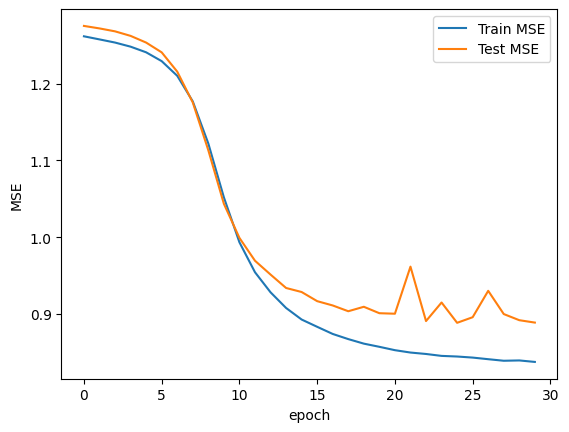

In [15]:
# Plot MSE
plt.plot(history.history['loss'], label="Train MSE")
plt.plot(history.history['val_loss'], label="Test MSE")
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [16]:
# 테스트 세트에서 사용자 ID와 영화 ID, 그리고 기타 특성을 6개 선택
user_ids = test_ratings.user_id.values[10:16]
movie_ids = test_ratings.movie_id.values[10:16]
other_features = test_ratings.iloc[:, 2:].values[10:16]  # 10번째부터 15번째까지의 샘플을 선택

# 모델을 사용하여 선택된 샘플에 대한 예측을 수행하고, 전체 평균(mu)을 더해 실제 평점 범위로 변환
predictions = model.predict([user_ids, movie_ids, other_features]) + mu

# 실제 평점과 예측 평점을 출력하여 비교
print("Actuals: \n", test_targets.values[10:16])  # 실제 평점 출력
print( )
print("Predictions: \n", predictions)  # 예측 평점 출력

1/1 [==============================] - 0s 115ms/step
Actuals: 
 [4 4 5 2 4 5]

Predictions: 
 [[3.9715507]
 [3.4803183]
 [4.532816 ]
 [3.229715 ]
 [3.9405704]
 [3.4750977]]


In [20]:
# 테스트 세트에서 사용자 ID, 영화 ID, 그리고 기타 특성을 전체 선택
user_ids = test_ratings.user_id.values
movie_ids = test_ratings.movie_id.values
other_features = test_ratings.iloc[:, 2:].values

# 모델을 사용하여 전체 테스트 세트에 대한 예측을 수행하고, 전체 평균(mu)을 더해 실제 평점 범위로 변환
y_pred = model.predict([user_ids, movie_ids, other_features]) + mu

# 실제 평점
y_true = test_targets.values

# 실제 값과 예측 값 사이의 평균 제곱 오차(MSE) 계산
mean_squared_error(y_true, y_pred, squared=True)

625/625 [==============================] - 2s 3ms/step


0.8889287332450598